# Compare models



## Questions
- How do I get the best F1 for binding? binding_1 vs binding_2, train just binding vs all ligands
- Does pLDDT affect performance?
- Plot RI against performance

In [1]:
# Import bind-af2-embed
import sys

sys.path.insert(0, '/home/george/Projects/Python/bind-af2-embed/src')
sys.path.insert(0, '/Users/tsitsiridis/Projects/bind-af2-embed/src')


# Import dependencies
%load_ext autoreload
%autoreload 2

import pandas as pd
from config import AppConfig
from plots import Plots
from ml.common import Performance
from data.dataset import Dataset, BindAnnotation
import numpy as np
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pathlib import Path
from IPython.display import display, HTML
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon
import plotly.express as px

# analysis path
analysis_path = Path('../data/output/analysis')

## Intro

In this notebook I want to compare the various models I run. I categorized my models according to input and classification task. 
There are 3 different input types:

- Only *Embeddings*
- Only *Distance maps*
- *Distance maps* and *embeddings*

There are 2 different classification tasks.

- *Ligand class* prediction: Each residue can belong to multiple classes (multi-class classification).
    - residues binding to metal ions
    - nucleic acids (DNA and RNA)
    - regular small molecules.
- *Binary prediction*: Each residue is classified as either binding or not (binary classification.



In [2]:
runs_df = pd.read_csv(analysis_path / 'runs.csv')
print(runs_df)

ligands=['metal', 'small', 'nuclear']
runs_df_filtered = runs_df[(runs_df.pLDDT_filter == 70) & (runs_df.prot_length_filter == 540)]

                               run              model train_mode  data_type  \
0          202207120223_combinedv1         combinedv1     ligand   combined   
1        202207121401_combinedv2_1       combinedv2_1     ligand   combined   
2        202207121144_combinedv2_2       combinedv2_2     ligand   combined   
3   202207121728_combinedv2_2_bind  combinedv2_2_bind    binding   combined   
4           202207120217_distmapv1          distmapv1     ligand    distmap   
5           202207120138_distmapv2          distmapv2     ligand    distmap   
6      202207121620_distmapv2_bind     distmapv2_bind    binding    distmap   
7           202207121113_embedding          embedding     ligand  embedding   
8           202207131333_embedding          embedding     ligand  embedding   
9           202207131414_embedding          embedding     ligand  embedding   
10     202207122348_embedding_bind     embedding_bind    binding  embedding   

    pLDDT_filter  prot_length_filter  
0           

### Read predictions files

In [3]:
def read_predictions_df(run: str, model: str, cutoff: float = 0.5, test: bool = False) -> Performance:
    eval_type = 'validation'
    if test:
        eval_type='test'
    
    predictions_path = Path('../data/output/ml/predictions')
    predictions_path = predictions_path / model / run / f'{eval_type}_total.csv'
    df = pd.read_csv(str(predictions_path))
    return df

def read_performance_df(run: str, model: str, test: bool = False) -> pd.DataFrame:
    eval_type = 'validation'
    if test:
        eval_type='test'
    config = AppConfig()
    perf_path = Path('../data/output/ml/models')
    perf_path = perf_path / model / run / f'model_{eval_type}_perf.csv'
    df = pd.read_csv(str(perf_path))
    return df

def pretty_mean_ci(mean, ci, is_percentage=True):
    if is_percentage:
        return f'%i ± %i%%' % (round(mean * 100), round(ci * 100))
    return f'%0.2f ± %0.2f' % (mean, ci)

def pretty_performance(df, columns):
    df = df.sort_values(by=columns, ascending=False)
    pretty_columns = {
        'f1': 'F1',
        'mcc': 'MCC',
        'prec': 'Precission',
        'rec': 'Recall',
        'acc': 'Accuracy'
    }

    def _pretty(x, columns):
        res = {}
        for column in columns:
            is_percentage = column.split('_')[0] != 'mcc'
            res[column] = pretty_mean_ci(x[column], x[column + "_ci"], is_percentage=is_percentage)
        return pd.Series(res)
    df = df.apply(lambda x: _pretty(x, columns), axis=1)
    df.columns = df.columns.map(lambda c: pretty_columns.get(c.split('_')[0], c))
    return df

def plot_single_performance(df, column, ax):
    means = df[column].to_list()
    cis = df[column + "_ci"].to_list()
    models = df.index.to_list()

    for idx, model in enumerate(models):
        ax.bar(idx, means[idx], yerr=cis[idx], align='center', alpha=0.5, ecolor='black', capsize=10, label=model)
    ax.yaxis.grid(True)
    ax.set_ylim([0, 1])    
    ax.legend()
    
def plot_multimodel_performance(df, columns, ax):
    pretty_columns = {
        'f1': 'F1',
        'mcc': 'MCC',
        'prec': 'Precission',
        'rec': 'Recall',
        'acc': 'Accuracy'
    }
    
    n=df.shape[0]
    if n < 3:
        barWidth = 0.3
    elif n == 3:
        barWidth = 0.25
    elif n == 4:
        barWidth = 0.20
    elif n > 4:
        barWidth = 0.1
    
    model_names = df.index
    model_means = [df[columns].iloc[i].to_list() for i in range(n)]
    model_cis = [df[list(map(lambda x: x + '_ci', columns))].iloc[i].to_list() for i in range(n)] 
    columns = [c.split('_')[0] for c in columns]
    columns = [pretty_columns.get(c, c) for c in columns]

    # Set position of bar on X axis
    # set width of bars
    r = [np.arange(len(columns))]
    for i in range(n - 1):
        r.append([x + barWidth for x in r[-1]])

    for i in range(n):
        ax.bar(r[i], model_means[i], yerr=model_cis[i], 
               width=barWidth, edgecolor='white', label=model_names[i])
    plt.xticks([i + barWidth for i in range(len(columns))], columns)
    ax.yaxis.grid(True)
    ax.set_ylim([0, 1]) 
    ax.legend()
    
    
def plot_roc(y_true, y_score, model: str, ax: plt.axes, col: str):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        color=col,
        lw=2,
        label=f"{model} (area = %0.2f)" % roc_auc,
    )


def plot_rocs(predictions, ax, ligand=None):
    colors = ["darkorange","green", "blue", "red"]
    def get_df(df, ligand=None):
        if ligand is None:
            return df
        return df[(df.ligand == ligand) & (df.cutoff == 0.5)]
    
    i = 0
    for model, df in predictions.items():
        plot_roc(get_df(df, ligand=ligand)['target'], get_df(df,ligand=ligand)['prediction'], model, ax,col=colors[i])
        i+=1

    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [4]:
# performance per run
def get_total(x, test = False):
    df = read_performance_df(run=x.run, model=x.model, test=test)
    total = df[df.tag == 'model_total'].iloc[0]
    total = pd.concat([total, x])
    return total
    
performance_df = runs_df.apply(lambda x: get_total(x), axis =1)
performance_df.set_index('run', inplace=True)


## Does the filtering affect the performance of the embeddings?

In [5]:
df = performance_df[performance_df.model == 'embedding']
df = df.reset_index().set_index(['run', 'pLDDT_filter', 'prot_length_filter'])
pretty_performance(df, ['f1_total', 'acc_total', 'prec_total', 'rec_total'])

,,,F1,Accuracy,Precission,Recall
run,pLDDT_filter,prot_length_filter,,,,
202207131414_embedding,0,811,30 ± 2%,95 ± 0%,42 ± 2%,29 ± 2%
202207121113_embedding,70,540,30 ± 2%,95 ± 0%,43 ± 2%,29 ± 2%
202207131333_embedding,70,811,29 ± 2%,95 ± 0%,42 ± 2%,28 ± 2%


### There seems to be no significant difference after the filtering. For the rest of the analysis I will only use runs that are filtered.

In [6]:
runs_df = runs_df[(runs_df.pLDDT_filter == 70) & (runs_df.prot_length_filter== 540)]
performance_df = performance_df[(performance_df.pLDDT_filter == 70) & (performance_df.prot_length_filter== 540)]
performance_df.set_index('model', inplace=True)
runs_df

,run,model,train_mode,data_type,pLDDT_filter,prot_length_filter
0,202207120223_combinedv1,combinedv1,ligand,combined,70,540
1,202207121401_combinedv2_1,combinedv2_1,ligand,combined,70,540
2,202207121144_combinedv2_2,combinedv2_2,ligand,combined,70,540
3,202207121728_combinedv2_2_bind,combinedv2_2_bind,binding,combined,70,540
4,202207120217_distmapv1,distmapv1,ligand,distmap,70,540
5,202207120138_distmapv2,distmapv2,ligand,distmap,70,540
6,202207121620_distmapv2_bind,distmapv2_bind,binding,distmap,70,540
7,202207121113_embedding,embedding,ligand,embedding,70,540
10,202207122348_embedding_bind,embedding_bind,binding,embedding,70,540


## Compare models that use distance maps

Before testing a model that combines both the distance maps and the embeddings, I wanted to see if I can train a model using just the distance maps an input. I used two different CNN models, distmapv1 and distmapv2. V2 is 1 layer deeper than V1.

### Ligand class prediction

Total results


,f1_total,acc_total,prec_total,rec_total
model,,,,
distmapv1,0.1 ± 0.1%,94.8 ± 0.5%,0.1 ± 0.2%,0.1 ± 0.1%
distmapv2,0.0 ± 0.0%,94.8 ± 0.5%,0.0 ± 0.0%,0.0 ± 0.0%


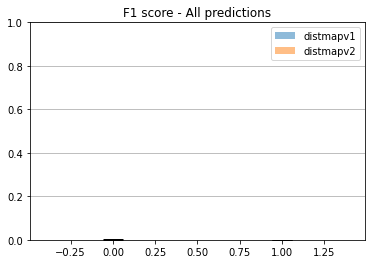

In [421]:
print("Total results")
df = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]
display(pretty_performance(df, ['f1_total', 'acc_total', 'prec_total', 'rec_total']))
fig, ax = plt.subplots()
ax.set_title("F1 score - All predictions")
plot_single_performance(df, 'f1_total', ax)

The distance maps alone do not contain enough information to deduce the ligand type using a CNN. None of the models seem to learn something.

### Binary prediction

In [422]:
print("Total results")
df_ligand = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]
df_binding = performance_df[(performance_df.data_type == 'distmap') & (performance_df.train_mode == 'ligand')]

print("Train mode: Ligand")
df = df_ligand
display(pretty_performance(df, ['f1_binding', 'acc_binding', 'prec_binding', 'rec_binding',
                               'f1_binding_2', 'acc_binding_2', 'prec_binding_2', 'rec_binding_2']))

print("Train mode: Binary")
df = df_binding
display(pretty_performance(df, ['f1_binding', 'acc_binding', 'prec_binding', 'rec_binding']))


Total results
Train mode: Ligand


,f1_binding,acc_binding,prec_binding,rec_binding,f1_binding_2,acc_binding_2,prec_binding_2,rec_binding_2
model,,,,,,,,
distmapv1,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%,0.1 ± 0.2%,89.7 ± 1.0%,0.1 ± 0.2%,0.2 ± 0.3%
distmapv2,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%


Train mode: Binary


,f1_binding,acc_binding,prec_binding,rec_binding
model,,,,
distmapv1,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%
distmapv2,0.0 ± 0.0%,89.8 ± 1.0%,0.0 ± 0.0%,0.0 ± 0.0%


### The performance of the binary classification was similar to multi-class prediction. None of the methods used were able to learn anything.

## Compare models that use combined data

I tried various ways to combine the distance maps and the embeddings into one final model. The final methods are categorized into 2 generation.

In the first generation models the data is merged into a 2D matrix. The distance maps are first flattened into a (T, 2T) matrix and then merged with the embeddings resulting in a matrix with dimensions (T, 2T + 1025). The data is then fed into a 2 layer CNN.

In the second generation models I am training 2 different models in parallel, one for the embeddings and one for the distance maps, which are then combined into a final model. The embeddings model is a 1D CNN and the distance map model is a 2D CNN that is transformed into 1D.


### Ligand class prediction

Total results


,f1_total,mcc_total,prec_total,rec_total
model,,,,
combinedv2_2,33 ± 2%,0.33 ± 0.02,43 ± 2%,32 ± 2%
combinedv2_1,30 ± 2%,0.31 ± 0.02,42 ± 2%,29 ± 2%
combinedv1,0 ± 0%,0.01 ± 0.00,1 ± 1%,1 ± 1%


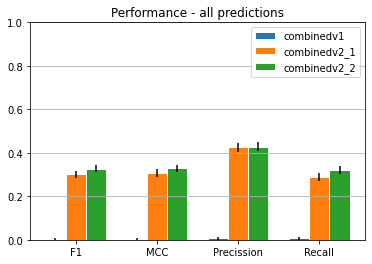

In [684]:
print("Total results")
columns = ['f1_total', 'mcc_total', 'prec_total', 'rec_total']
df = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
display(pretty_performance(df, columns))
fig, ax = plt.subplots()
ax.set_title("Performance - all predictions")
plot_multimodel_performance(df, columns, ax)

metal


,f1_metal,mcc_metal,prec_metal,rec_metal
model,,,,
combinedv2_1,19 ± 2%,0.19 ± 0.02,21 ± 2%,20 ± 2%
combinedv2_2,18 ± 2%,0.18 ± 0.02,20 ± 2%,19 ± 2%
combinedv1,0 ± 0%,0.00 ± 0.00,0 ± 0%,0 ± 0%


small


,f1_small,mcc_small,prec_small,rec_small
model,,,,
combinedv2_2,18 ± 2%,0.17 ± 0.01,28 ± 2%,16 ± 1%
combinedv2_1,15 ± 1%,0.15 ± 0.01,28 ± 2%,12 ± 1%
combinedv1,0 ± 0%,-0.00 ± 0.00,0 ± 0%,0 ± 0%


nuclear


,f1_nuclear,mcc_nuclear,prec_nuclear,rec_nuclear
model,,,,
combinedv2_1,5 ± 1%,0.04 ± 0.01,5 ± 1%,6 ± 1%
combinedv2_2,5 ± 1%,0.04 ± 0.01,5 ± 1%,5 ± 1%
combinedv1,0 ± 0%,0.00 ± 0.00,0 ± 0%,0 ± 0%


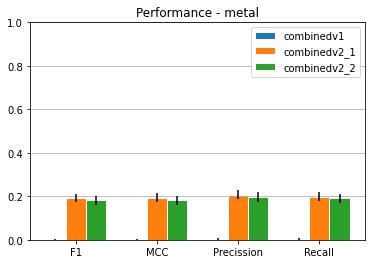

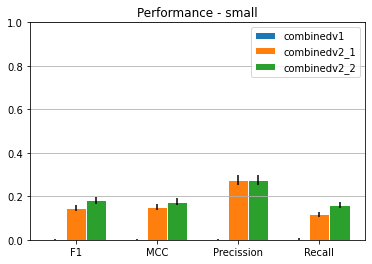

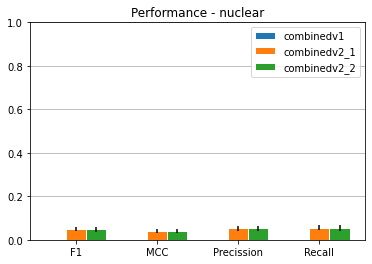

In [685]:
for ligand in ligands:
    print(ligand)
    columns =  ['f1_' + ligand, 'mcc_' + ligand, 'prec_' + ligand, 'rec_' + ligand]
    display(pretty_performance(df, columns))
    fig, ax = plt.subplots()
    ax.set_title('Performance - ' + ligand)
    plot_multimodel_performance(df,columns, ax)


The first generation model fails to learn anything has an F1 score close to 0. In the second generation the story is different. The deeper CNN (*combinedv2_2*) performs better for small molecules, whereas the other ligand classes have a similar performance.

### Binary prediction

Total results


,f1_binding,mcc_binding,prec_binding,rec_binding
model,,,,
combinedv2_2_ligand_2,37 ± 2%,0.35 ± 0.02,45 ± 2%,39 ± 2%
combinedv2_1_ligand_2,35 ± 2%,0.34 ± 0.02,47 ± 2%,35 ± 2%
combinedv2_2_ligand,33 ± 2%,0.33 ± 0.02,50 ± 2%,30 ± 2%
combinedv2_2_bind_binary,33 ± 2%,0.33 ± 0.02,50 ± 2%,30 ± 2%
combinedv2_1_ligand,30 ± 2%,0.30 ± 0.02,50 ± 2%,26 ± 2%


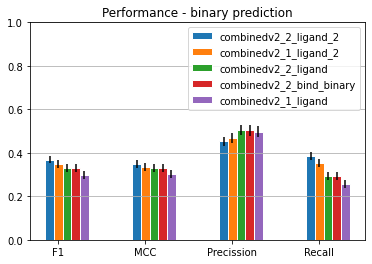

In [686]:
print("Total results")

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_ligand_1 = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
df_ligand_1 = df_ligand_1[columns + list(map(lambda x: x + "_ci", columns))]
df_ligand_1.index = df_ligand_1.index.map(lambda x: x + "_ligand")

columns_2 = ['f1_binding_2', 'mcc_binding_2', 'prec_binding_2', 'rec_binding_2']
df_ligand_2 = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'ligand')]
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.index = df_ligand_2.index.map(lambda x: x + "_ligand_2")
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.columns = columns + list(map(lambda x: x + "_ci", columns))

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_binding = performance_df[(performance_df.data_type == 'combined') & (performance_df.train_mode == 'binding')]
df_binding = df_binding[columns + list(map(lambda x: x + "_ci", columns))]
df_binding.index = df_binding.index.map(lambda x: x + "_binary")

df = pd.concat([df_ligand_1, df_ligand_2, df_binding])
df = df.loc[['combinedv2_2_ligand_2', 
             'combinedv2_1_ligand_2', 
             'combinedv2_2_ligand', 
             'combinedv2_2_bind_binary',
             'combinedv2_1_ligand']]

display(pretty_performance(df, columns))

fig, ax = plt.subplots()
ax.set_title("Performance - binary prediction")
plot_multimodel_performance(df, columns, ax)

The first generation model did not learn anything for the binary prediction task either. The best performing model in terms of F1 score is the model combinedv2_2. 

The best performing method for the binary classification is ligand_2. The model that was trained solely on the binding annotation performed the worst for the model combinedv2_2.

### For both tasks the model *combinedv2_2* performes the best in comparison to the other combined models

## Compare embeddings against combined models using the test set

### Ligand classification

In [7]:
test_df = runs_df_filtered.set_index('run').loc[['202207121113_embedding', '202207121144_combinedv2_2']].reset_index(). \
    apply(lambda x: get_total(x, test=True), axis =1).set_index('model')
predictions = {
    'combinedv2_2': read_predictions_df(run ='202207121144_combinedv2_2', model='combinedv2_2', test=True),
    'embedding': read_predictions_df(run ='202207121113_embedding', model='embedding', test=True),
}

In [8]:

def pretty_performance(df, columns):
    df = df.sort_values(by=columns, ascending=False)
    pretty_columns = {
        'f1': 'F1',
        'mcc': 'MCC',
        'prec': 'Precission',
        'rec': 'Recall',
        'acc': 'Accuracy'
    }

    def _pretty(x, columns):
        res = {}
        for column in columns:
            is_percentage = column.split('_')[0] != 'mcc'
            res[column] = pretty_mean_ci(x[column], x[column + "_ci"], is_percentage=is_percentage)
        return pd.Series(res)
    df = df.apply(lambda x: _pretty(x, columns), axis=1)
    df.columns = df.columns.map(lambda c: pretty_columns.get(c.split('_')[0], c))
    return df


Total results


,F1,MCC,Precission,Recall
model,,,,
combinedv2_2,35 ± 2%,0.37 ± 0.03,56 ± 3%,31 ± 3%
embedding,32 ± 2%,0.34 ± 0.03,56 ± 4%,28 ± 3%


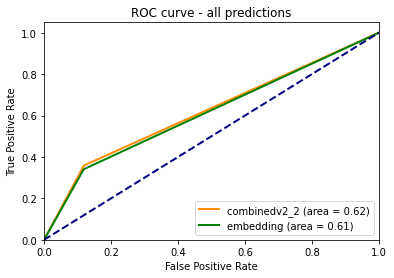

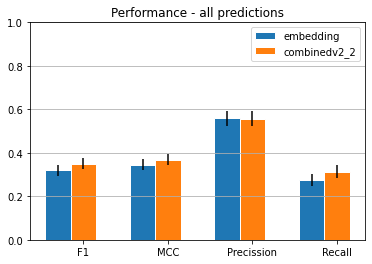

In [9]:
print("Total results")
fig, ax = plt.subplots()
ax.set_title("ROC curve - all predictions")
plot_rocs(predictions=predictions, ax=ax)

df = test_df
columns = ['f1_total', 'mcc_total', 'prec_total', 'rec_total']
display(pretty_performance(df, columns))
fig, ax = plt.subplots()
ax.set_title("Performance - all predictions")
plot_multimodel_performance(df, columns, ax)

small


,F1,MCC,Precission,Recall
model,,,,
combinedv2_2,26 ± 3%,0.26 ± 0.03,43 ± 4%,22 ± 3%
embedding,22 ± 3%,0.23 ± 0.03,42 ± 5%,17 ± 2%


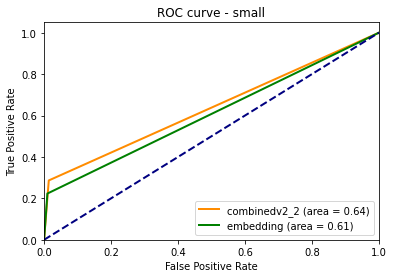

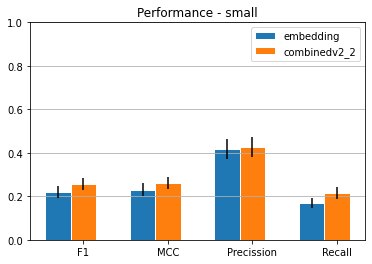

In [11]:
# for ligand in ligands:
ligand = 'small'
print(ligand)
fig, ax = plt.subplots()
ax.set_title("ROC curve - " + ligand)
plot_rocs(predictions=predictions, ax=ax, ligand=ligand)
columns =  ['f1_' + ligand, 'mcc_' + ligand, 'prec_' + ligand, 'rec_' + ligand]
display(pretty_performance(df, columns))
fig, ax = plt.subplots()
ax.set_title('Performance - ' + ligand)
plot_multimodel_performance(df,columns, ax)

For small molecules the combined method outperforms the method with just the embeddings.

### Binary prediction

Total results


,F1,MCC,Precission,Recall
combinedv2_2,39 ± 3%,0.39 ± 0.03,58 ± 4%,37 ± 3%
embedding,37 ± 3%,0.38 ± 0.03,59 ± 4%,33 ± 3%


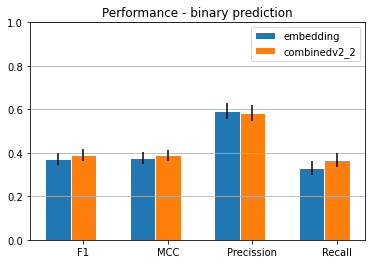

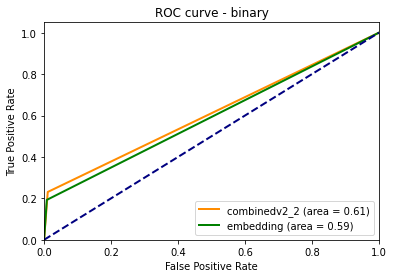

In [15]:
print("Total results")

columns = ['f1_binding', 'mcc_binding', 'prec_binding', 'rec_binding'] 
df_ligand_1 = df[columns + list(map(lambda x: x + "_ci", columns))]
df_ligand_1.index = df_ligand_1.index.map(lambda x: x + "_ligand")

columns_2 = ['f1_binding_2', 'mcc_binding_2', 'prec_binding_2', 'rec_binding_2']
df_ligand_2 = df[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.index = df_ligand_2.index.map(lambda x: x + "_ligand_2")
df_ligand_2 = df_ligand_2[columns_2 + list(map(lambda x: x + "_ci", columns_2))]
df_ligand_2.columns = columns + list(map(lambda x: x + "_ci", columns))


df_binary = pd.concat([df_ligand_1, df_ligand_2])
df_binary = df_binary.loc[["embedding_ligand_2", "combinedv2_2_ligand_2"]]
df_binary.index = ['embedding', 'combinedv2_2']

tmp = pretty_performance(df_binary, columns)
display(tmp)

fig, ax = plt.subplots()
ax.set_title("Performance - binary prediction")
plot_multimodel_performance(df_binary, columns, ax)

fig, ax = plt.subplots()
ax.set_title("ROC curve - binary")
plot_rocs(predictions, ax, 'binding')

The combined model outperfoms the model that includes just the embeddings for the binary prediction as well.

### Is the difference in performance significant?

acc_total
Ttest_relResult(statistic=2.234494520022145, pvalue=0.026196872705288702)
WilcoxonResult(statistic=7774.0, pvalue=0.04101410527577648)
prec_total
Ttest_relResult(statistic=-0.5182568868500983, pvalue=0.6046662172161926)
WilcoxonResult(statistic=4628.0, pvalue=0.021452349312795074)
rec_total
Ttest_relResult(statistic=8.316485247578203, pvalue=3.3432675902923846e-15)
WilcoxonResult(statistic=1708.0, pvalue=1.2425645179320412e-15)
f1_total
Ttest_relResult(statistic=6.397433300203239, pvalue=6.159748544880416e-10)
WilcoxonResult(statistic=4619.5, pvalue=1.5020968320716293e-10)
mcc_total
Ttest_relResult(statistic=4.7207491922650755, pvalue=3.6310585838466552e-06)
WilcoxonResult(statistic=7226.5, pvalue=1.586445175847866e-06)


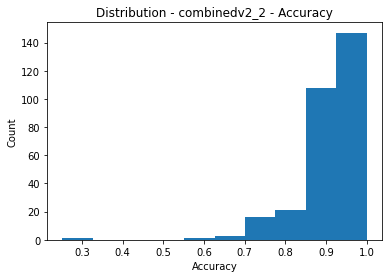

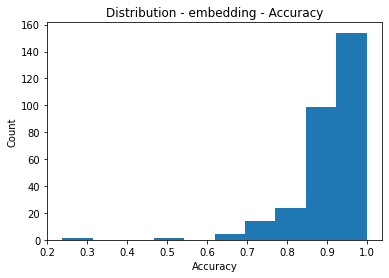

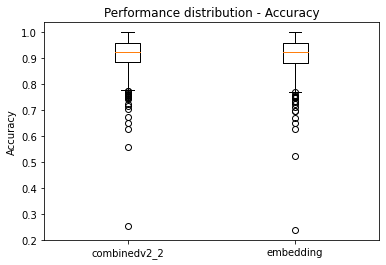

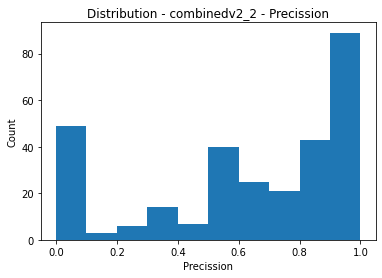

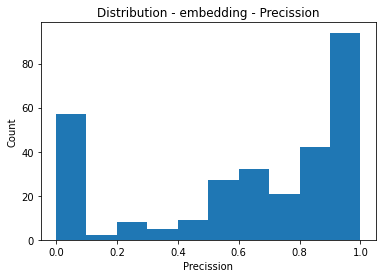

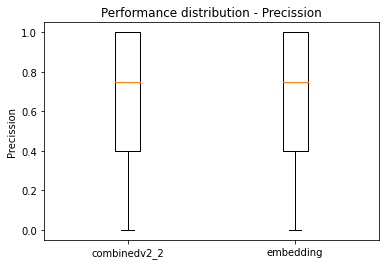

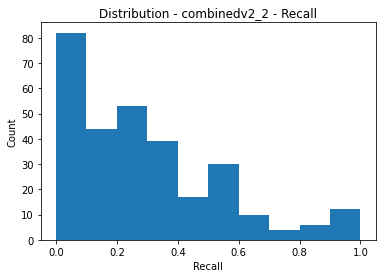

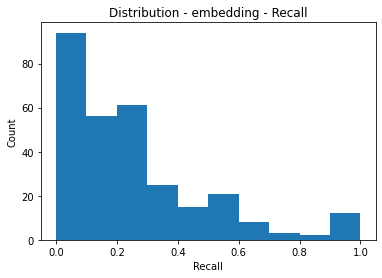

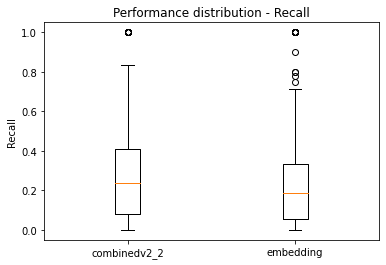

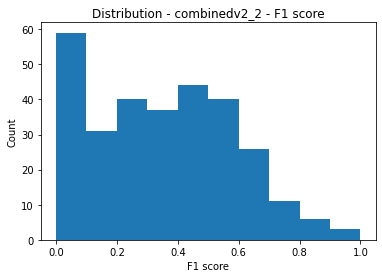

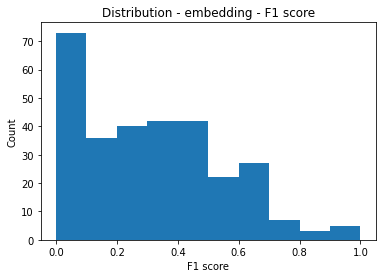

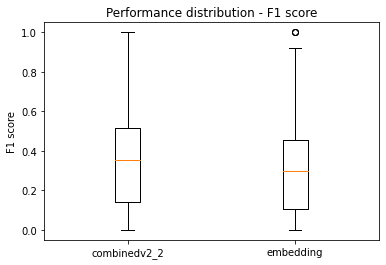

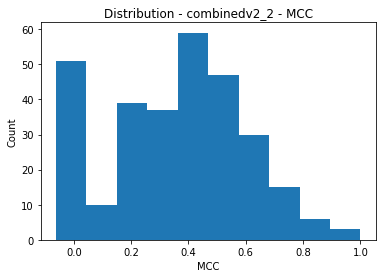

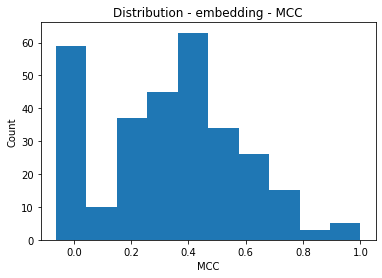

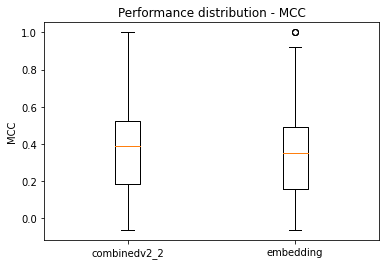

In [875]:
ligand = 'binding'

performance_per_model_per_stat = {}
prot_ids = None
for model, df in predictions.items():
    df = df[(df.cutoff == 0.5)]
    if ligand is not None:
        df = df[df.ligand == ligand]
    perf_per_protein = df.groupby('prot_id'). \
            apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot, tag='total')))
    for row in perf_per_protein.T.iterrows():
        name = row[0]
        if name in performance_per_model_per_stat:
            perf = performance_per_model_per_stat[name]
        else:
            perf = {}
            performance_per_model_per_stat[name] = perf
        if prot_ids is None:
            prot_ids = row[1].sort_index().index
        perf[model] = row[1].sort_index().to_numpy()

for stat, perf in performance_per_model_per_stat.items():
    print(stat)
    pretty_columns = {
        'f1': 'F1 score',
        'mcc': 'MCC',
        'prec': 'Precission',
        'rec': 'Recall',
        'acc': 'Accuracy'
    }
    c = pretty_columns.get(stat.split('_')[0], stat)
    
    for model, stats in perf.items():
        fig, ax = plt.subplots()
        ax.hist(stats)
        ax.set_title(f'Distribution - {model} - {c}')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
    
    fig, ax = plt.subplots()
    ax.set_title('Performance distribution - ' + c)
    ax.boxplot(perf.values())
    ax.set_xticklabels(perf.keys())
    ax.set_ylabel(c)
    print(ttest_rel(perf['combinedv2_2'], perf['embedding']))
    print(wilcoxon(perf['combinedv2_2'], perf['embedding']))



perf = performance_per_model_per_stat['f1_total']
pretty_columns = {
    'f1': 'F1 score',
    'mcc': 'MCC',
    'prec': 'Precission',
    'rec': 'Recall',
    'acc': 'Accuracy'
}
c = pretty_columns.get(stat.split('_')[0], stat)
tmp = pd.DataFrame({'combinedv2_2': perf['combinedv2_2'], 'embedding': perf['embedding'], "protein": prot_ids})
fig = px.scatter(tmp, x='combinedv2_2', y='embedding', hover_name='protein', title='embedding vs combinedv2_2')
fig.show()

### Combinedv2_2 has a better performance than the embeddings alone

## Is there a correlation between performance and RI?

Text(0.5, 1.0, 'Performance per cutoff')

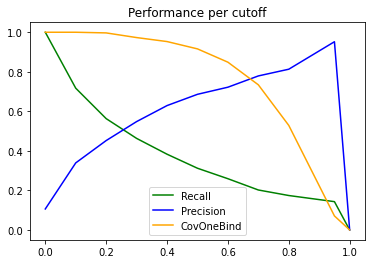

In [742]:
df = predictions['combinedv2_2']
rec = []
prec = []
covonebind = []

# add more cutoffs
new_cutoffs = [0.95]
for nc in new_cutoffs:
    tmp = df.loc[df.cutoff == 0.5]
    tmp.loc[tmp.cutoff == 0.5, 'cutoff'] = nc
    df = pd.concat([df, tmp]).reset_index(drop=True)
    df.loc[df.cutoff == nc, 'prediction'] = 0
    df.loc[(df.cutoff == nc) & (df.prob >= nc), 'prediction'] = 1

cutoffs = np.sort(df.cutoff.unique())
for cutoff in cutoffs:
    performance = Performance.df_to_performance(df[df.cutoff==cutoff], is_train=False)
    rec.append(performance['rec_binding'])
    prec.append(performance['prec_binding'])
    covonebind.append(performance['covonebind_binding'])

fig, ax = plt.subplots()
ax.plot(cutoffs, rec,color='green', label='Recall')
ax.plot(cutoffs, prec,color='blue', label='Precision')
ax.plot(cutoffs, covonebind,color='orange', label = "CovOneBind")
ax.legend()
ax.set_title('Performance per cutoff')

### Is there a correlation between performance and pLDDT?

In [578]:
# retrieve pLDDTs
dataset = Dataset.full_dataset(config=AppConfig().input)
dataset = dataset.get_subset(config=AppConfig().input, mode='test')
plddts = {key: prot.structure.avg_plddt() for key, prot in dataset.proteins.items()}
plddts = pd.Series(plddts)
plddts.name = 'pLDDT'

Distogram length is different for id: Q00277. Seq length: 169, Distogram length: 168. Skipping...
Distogram length is different for id: P84801. Seq length: 121, Distogram length: 120. Skipping...
Distogram length is different for id: Q9NZV6. Seq length: 116, Distogram length: 115. Skipping...
Distogram length is different for id: C8BD48. Seq length: 99, Distogram length: 98. Skipping...


In [26]:
df = predictions['combinedv2_2']
df = df[(df.cutoff == 0.5) & (df.ligand == 'binding')]
# df = df[(df.cutoff == 0.5)]
perf_per_protein = df.groupby('prot_id'). \
            apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot, tag='')))
df = perf_per_protein.join(plddts, how='inner')

NameError: name 'plddts' is not defined

Spearman’s correlation: 0.302
Best performing proteins


,acc_,prec_,rec_,f1_,mcc_,pLDDT
O59248,1.000,1.000,1.000,1.000,1.000,93.992805
Q3E840,1.000,1.000,1.000,1.000,1.000,87.280015
P95855,0.995,0.857,1.000,0.923,0.923,94.148556
P45850,0.995,0.800,1.000,0.889,0.892,94.866132
Q7VWF8,0.990,0.750,1.000,0.857,0.861,97.541989
Q8A8Q1,0.995,0.750,1.000,0.857,0.864,87.810321
P75914,0.988,0.889,0.800,0.842,0.837,96.097583
Q9WZC6,0.985,1.000,0.714,0.833,0.838,97.101156
Q06241,0.990,0.800,0.800,0.800,0.795,96.764194
Q5SJ80,0.982,1.000,0.625,0.769,0.783,92.982058


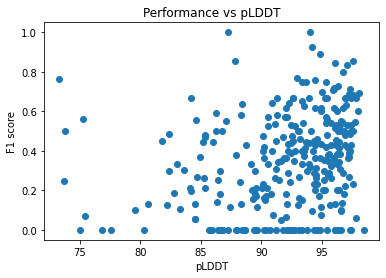

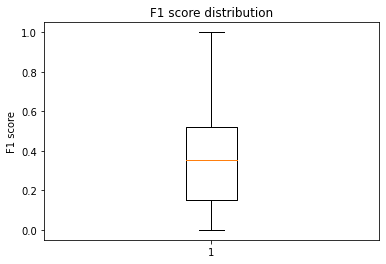

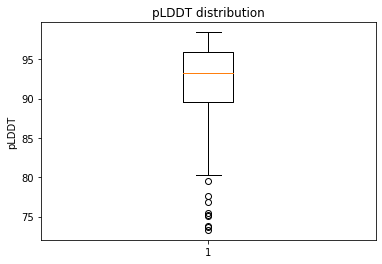

In [632]:
fig, ax = plt.subplots()
ax.plot(df.pLDDT, df.f1_, 'o')
ax.set_xlabel('pLDDT')
ax.set_ylabel('F1 score')
ax.set_title("Performance vs pLDDT")
corr, _ = spearmanr(df.pLDDT, df.f1_)
print('Spearman’s correlation: %.3f' % corr)

fig, ax = plt.subplots()
ax.boxplot(df.f1_)
ax.set_ylabel('F1 score')
ax.set_title("F1 score distribution")

fig, ax = plt.subplots()
ax.boxplot(df.pLDDT)
ax.set_ylabel('pLDDT')
ax.set_title("pLDDT distribution")

### Best performing proteins

In [34]:
df = predictions['combinedv2_2']
df = df[(df.cutoff == 0.5) & (df.ligand == 'binding')]

df = df.groupby('prot_id'). \
            apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot, tag='')))

# best protein predictions
print('Best performing proteins')
df.sort_values('f1_', ascending=False)[:10]

Best performing proteins


,acc_,prec_,rec_,f1_,mcc_
prot_id,,,,,
P47224,1.0,1.0,1.0,1.0,1.0
P67870,1.0,1.0,1.0,1.0,1.0
Q9NWV4,1.0,1.0,1.0,1.0,1.0
P22139,1.0,1.0,1.0,1.0,1.0
Q8RM02,1.0,1.0,1.0,1.0,1.0
Q9KCV1,1.0,1.0,1.0,1.0,1.0
P27999,1.0,1.0,1.0,1.0,1.0
P77214,1.0,1.0,1.0,1.0,1.0
P39146,1.0,1.0,1.0,1.0,1.0


There is no obvious correlation between pLDDT and performance. There are not enough proteins with a pLDDT < 70 to assess the relationship

### Is there a correlation between performance and protein size?

Spearman’s correlation: -0.001


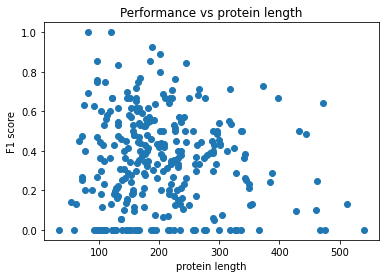

In [883]:
# retrieve pLDDTs
plengths = {key: len(prot) for key, prot in dataset.proteins.items()}
plengths = pd.Series(plengths)
plengths.name = 'plength'

df = predictions['combinedv2_2']
df = df[(df.cutoff == 0.5) & (df.ligand == 'binding')]
# df = df[(df.cutoff == 0.5)]
perf_per_protein = df.groupby('prot_id'). \
            apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot, tag='')))

df = perf_per_protein.join(plengths, how='inner')
fig, ax = plt.subplots()
ax.plot(df.plength, df.f1_, 'o')
ax.set_xlabel('protein length')
ax.set_ylabel('F1 score')
ax.set_title("Performance vs protein length")
corr, _ = spearmanr(df.plength, df.f1_)
print('Spearman’s correlation: %.3f' % corr)

### There seems to be no correlation between protein length and performance

### Visualize best predictions

In [23]:
dataset = Dataset.full_dataset(config=AppConfig().input)
test_df = runs_df_filtered.set_index('run').loc[['202207121113_embedding', '202207121144_combinedv2_2']].reset_index(). \
    apply(lambda x: get_total(x, test=True), axis =1).set_index('model')
predictions = {
    'combinedv2_2': read_predictions_df(run ='202207121144_combinedv2_2', model='combinedv2_2', test=False),
    'embedding': read_predictions_df(run ='202207121113_embedding', model='embedding', test=False),
}

Distogram length is different for id: Q00277. Seq length: 169, Distogram length: 168. Skipping...
Distogram length is different for id: P84801. Seq length: 121, Distogram length: 120. Skipping...
Distogram length is different for id: Q9NZV6. Seq length: 116, Distogram length: 115. Skipping...
Distogram length is different for id: C8BD48. Seq length: 99, Distogram length: 98. Skipping...


Target


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Embedding


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Combined


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Target
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 13:54:26 2022 Construct fuzzy simplicial set
Wed Jul 20 13:54:26 2022 Finding Nearest Neighbors
Wed Jul 20 13:54:26 2022 Finished Nearest Neighbor Search
Wed Jul 20 13:54:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 13:54:26 2022 Finished embedding


Embedding
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 13:54:26 2022 Construct fuzzy simplicial set
Wed Jul 20 13:54:27 2022 Finding Nearest Neighbors
Wed Jul 20 13:54:27 2022 Finished Nearest Neighbor Search
Wed Jul 20 13:54:27 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 13:54:28 2022 Finished embedding


Combined
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 13:54:28 2022 Construct fuzzy simplicial set
Wed Jul 20 13:54:28 2022 Finding Nearest Neighbors
Wed Jul 20 13:54:28 2022 Finished Nearest Neighbor Search
Wed Jul 20 13:54:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 13:54:29 2022 Finished embedding


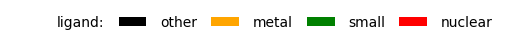

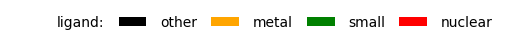

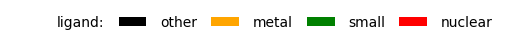

In [25]:
# best small molecule prediction
# prot_id = 'A9CKY2'

# best nuclear prediction
# prot_id = 'P03699'

# prot_id = 'O15496'

# prot_id = 'Q06241'

prot_id = 'P68919'

# best metal prediction
# prot_id = 'Q96GX9'

# best overall prediction
# prot_id = 'Q3E840'

# # best binding prediction
# prot_id = 'P95855'

# print prediction RI


# get prediction tensor per protein
df_emb = predictions['embedding']
df_emb = df_emb[(df_emb.cutoff == 0.5)]
df_comb = predictions['combinedv2_2']
df_comb = df_comb[(df_comb.cutoff == 0.5)]

bind_annot_names = BindAnnotation.names()

def get_pred_tensor(prot_id, df):
    df_prot = df[df.prot_id==prot_id]
    pred_tensor_list = [df_prot[df_prot.ligand==name]['prediction'].to_numpy() for name in bind_annot_names]
    return np.stack(pred_tensor_list, axis=1)

prot = dataset.proteins[prot_id]
target_tensor = prot.bind_annotation.tensor
print("Target")
# show target
prot.show_structure(color='ligand')
# show prediction
print("Embedding")
prot.bind_annotation.tensor = get_pred_tensor(prot_id, df_emb)
prot.show_structure(color='ligand')
print("Combined")
prot.bind_annotation.tensor = get_pred_tensor(prot_id, df_comb)
prot.show_structure(color='ligand')
# reset
prot.bind_annotation.tensor = target_tensor


# show target
print("Target")
prot.show_umap()
# show prediction
print("Embedding")
prot.bind_annotation.tensor = get_pred_tensor(prot_id, df_emb)
prot.show_umap()
# show prediction
print("Combined")
prot.bind_annotation.tensor = get_pred_tensor(prot_id, df_comb)
prot.show_umap()
# reset
prot.bind_annotation.tensor = target_tensor

